In [1]:
%matplotlib inline
# File formats
import ROOT
import uproot, h5py
# Data manipulation
import datetime as dt
import numpy as np
import pandas as pd
# Plotting
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
# Others
from tqdm.notebook import tqdm
import sys, importlib
from importlib import reload
from pathlib import Path
# Personal
import hepkit.hepData as hd
import hepkit.hepIO as hio
import hepkit.hepPlot as hp
import hepkit.hepFormat as hf
# Colors
mc = [
    [35/255,55/255,59/255],
    [237/255,138/255,46/255],
    [131/255,40/255,0/255],
    [0/255,123/255,68/255],
    [107/255,60/255,79/255],
    [118/255,93/255,68/255],
    [62/255,79/255,51/255],
    [147/255,161/255,161/255]
]


# Add current directory to import path and import locals
pathFromHere = Path("__file__").parent.absolute()
sys.path.insert(1, pathFromHere)
import Libraries.charge_library as cl
import Libraries.light_library as ll
import Libraries.meta_library as ml
import Libraries.evd_library as evd
import Libraries.michelCandidate_class as mic

hf.DefaultSetup()

Welcome to JupyROOT 6.22/08


In [5]:
reload(ml)
cpath = '/home/dporzio/Data/Michel/michel_datalog_2021_04_04_16_19_13_CEST_evd.h5'
ldir = '/home/dporzio/Data/Michel'
ml.FindPartnerLightFile(cpath,ldir)

Charge file 2021_04_04_16_19_13 has been matched to light file ['20210404_161914.data'].


(           event         sn  ch       utime_ms          tai_ns
 0              1  175854781  18  1617545955347  70657444649025
 1              1  175854781  32  1617545955347  70657444649025
 2              1  175854781  31  1617545955347  70657444649025
 3              1  175854781  30  1617545955347  70657444649025
 4              1  175854781  29  1617545955347  70657444649025
 ...          ...        ...  ..            ...             ...
 21973179  189424  175780172  37  1617547152737       744448010
 21973180  189424  175780172  36  1617547152737       744448010
 21973181  189424  175780172  35  1617547152737       744448010
 21973182  189424  175780172  34  1617547152737       744448010
 21973183  189424  175780172  32  1617547152737       744448010
 
 [21973184 rows x 5 columns],
 '/home/dporzio/Data/Michel/rwf_20210404_161914.data.root')

In [7]:
%%time
reload(cl)
reload(ll)

### FILENAMES
cpath = '/home/dporzio/Data/Michel/michel_datalog_2021_04_04_16_19_13_CEST_evd.h5'
ldir = '/home/dporzio/Data/Michel'

### LOAD LIGHT DATA
# Uproot
ldata, lpath = ml.FindPartnerLightFile(cpath,ldir)
# Root
rfile = ROOT.TFile.Open(lpath, 'read')
rwf = rfile.Get('rwf')
# Convert utime to a better usable format
ldata['utime_ms'] = ldata['utime_ms'].astype(np.int64)

### LOAD CHARGE DATA
cdata = h5py.File(cpath,'r')

h_events = cdata['events']
h_trigs = cdata['ext_trigs']
h_tracks = cdata['tracks']
h_hits = cdata['hits']
h_info = cdata['info'].attrs

print("events:",[t for t in cdata['events'].dtype.names])
print("tracks:",[t for t in cdata['tracks'].dtype.names])
print("hits:",[t for t in cdata['hits'].dtype.names])
print("ext_trigs:",[t for t in cdata['ext_trigs'].dtype.names])
print("info:",[t for t in (cdata['info'].attrs).keys()])

### LOAD GEOMETRY DATA
geometryHelper = cl.GetGeometryHelper(h_info)

# reload(evd)
# reload(cl)
# evd.SmallEventDisplay(15,cpath,cdata,geometryHelper,rot=45,showTracks=True,trackOffset=100)

Charge file 2021_04_04_16_19_13 has been matched to light file ['20210404_161914.data'].
events: ['evid', 'track_ref', 'hit_ref', 'nhit', 'q', 'ts_start', 'ts_end', 'ntracks', 'ext_trig_ref', 'n_ext_trigs', 'unix_ts', 'q_raw']
tracks: ['track_id', 'event_ref', 'hit_ref', 'theta', 't0', 'phi', 'xp', 'yp', 'nhit', 'q', 'ts_start', 'ts_end', 'residual', 'length', 'start', 'end', 'q_raw', 't0_type']
hits: ['hid', 'px', 'py', 'ts', 'q', 'iochannel', 'iogroup', 'chipid', 'channelid', 'geom', 'event_ref', 'q_raw']
ext_trigs: ['trig_id', 'event_ref', 'ts', 'type']
info: ['clock_period', 'configuration_file', 'electron_lifetime_file', 'geometry_file', 'pedestal_file', 'source_file', 'vdrift']
CPU times: user 5 s, sys: 2.04 s, total: 7.04 s
Wall time: 8.66 s


In [9]:
def GetOrientation(start,end):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    dz = end[2] - start[2]
    theta = np.arctan2(np.linalg.norm([dx,dy]),dz)
    phi = np.arctan2(dy,dx)
    return [dx,dy,dz], theta, phi

def EuDistance(p1,p2):
    return np.sqrt(np.power(p1[0]-p2[0],2.) + np.power(p1[1]-p2[1],2.) + np.power(p1[2]-p2[2],2.))

In [ ]:
reload(mic)
# Temporary list
michelList = []

# Selection parameters
sel_minNumTracks = 2
sel_maxNumTracks = 15
sel_longestTrackMinLength = 20
sel_xEdge = np.array([-308,308])
sel_yEdge = np.array([-618,618])
sel_zEdge = np.array([-315,315])
sel_xPadding = np.array([30,-30])
sel_yPadding = np.array([30,-30])
sel_zPadding = np.array([30,-30])
# Stitching parameters
stitch_maxDeltaTheta = 0.2
stitch_maxDeltaPhi = 0.2
stitch_maxGap = 300
# Michel electron parameters
electron_maxGap = 20
electron_minDeltaTheta = 0.4
electron_minDeltaPhi = 0.4

# Calculate additional parameters
sel_xCont = sel_xEdge+sel_xPadding
sel_yCont = sel_yEdge+sel_yPadding
sel_zCont = sel_zEdge+sel_zPadding

##########################
## EVENT LOOP
##########################
for ev in tqdm(test_events):
    evid = ev['evid']
    nTracks = ev['ntracks']
    
    ##########################
    ## EVENT-WISE REQUIREMENTS
    ##########################
    
    # Ignore event if not sufficient number of tracks
    if nTracks<sel_minNumTracks:
        continue
    # Ignore event if too many tracks
    if nTracks>sel_maxNumTracks:
        continue
    
    # Get tracks
    evtracks = h_tracks[ev['track_ref']]
    # Ignore event if longest track is not long enough
    maxLength = np.max(evtracks['length'])
    if maxLength<sel_longestTrackMinLength:
        continue
    
    ##########################
    ## FIRST TRACK LOOP
    ##########################
    for i,tr in enumerate(evtracks):
        # Determine if candidate has start and end flipped
        # For Michel candidate max(y) start, min(y) end
        cand_flipped = tr['start'][1] < tr['end'][1]
        # If flipped, swap start and end points
        if cand_flipped:
            cand_start = tr['end'][0:3]
            cand_end = tr['start'][0:3]
        else:
            cand_start = tr['start'][0:3]
            cand_end = tr['end'][0:3]

        # Determine whether candidate has entered or exited the detector
        cand_xEntered = cand_start[0]<sel_xCont[0] or cand_start[0]>sel_xCont[1]
        cand_zEntered = cand_start[2]<sel_zCont[0] or cand_start[2]>sel_zCont[1]
        cand_topEntered = cand_start[1]<sel_yCont[0]
        cand_botEntered = cand_start[1]>sel_yCont[1]
        cand_entered = cand_xEntered or cand_zEntered or cand_topEntered or cand_botEntered
        ##########################
        cand_xExited = cand_end[0]<sel_xCont[0] or cand_end[0]>sel_xCont[1]
        cand_zExited = cand_end[2]<sel_zCont[0] or cand_end[2]>sel_zCont[1]
        cand_topExited = cand_end[1]<sel_yCont[0]
        cand_botExited = cand_end[1]>sel_yCont[1]
        cand_exited = cand_xExited or cand_zExited or cand_topExited or cand_botExited
        
        # Entering track which is contained is condition sufficient to consider Michel candidate
        candidateCondition = cand_entered and (not cand_exited)
        # If we haven't met candidate condition let's move on to next tracks
        if not candidateCondition:
            continue
        # Otherwise let's create the candidate
        michel = mic.MichelCandidate(evid,tr['track_id'],i)
        michel.cont_originallyFlipped = cand_flipped
        michel.cont_entered = cand_entered
        michel.cont_xEntered = cand_xEntered
        michel.cont_zEntered = cand_zEntered
        michel.cont_topEntered = cand_topEntered
        michel.cont_botEntered = cand_botEntered
        michel.pos_start = cand_start
        michel.pos_end = cand_end
        # Let's recalculate the angles because we might have flipped the tracks
        direction, theta, phi = GetOrientation(michel.pos_start,michel.pos_end)
        michel.orient_direction = direction
        michel.orient_theta = theta
        michel.orient_phi = phi
        
        # Let's build now a list of indices pertaining to all the other tracks
        i_other = np.delete(np.arange(nTracks),i)
        # Now we can loop throughout all the other tracks
        stitch_dtype = [('index',int),('start_x',float),('start_y',float),('start_z',float),('end_x',float),('end_y',float),('end_z',float)]
        stitchingCandidates = []
        ##########################
        ## STITCH TRACKS LOOP
        ##########################
        for j in i_other:
            second = evtracks[j]
            # If flipped we need to unflip it, recalculate theta and phi for possible stitching
            second_flipped = second['start'][1] < second['end'][1]
            # If flipped, swap start and end points
            if second_flipped:
                second_start = second['end']
                second_end = second['start']
            else:
                second_start = second['start']
                second_end = second['end']
            # Calculate difference in orientation
            second_direction, second_theta, second_phi = GetOrientation(second_start,second_end)
            deltaTheta = np.abs(michel.orient_theta - second_theta)
            deltaPhi = np.abs(michel.orient_phi - second_phi)
            # If below threshold promote secondary track to stitching candidate
            if deltaTheta<stitch_maxDeltaTheta and deltaPhi<stitch_maxDeltaPhi:
                stitchingCandidates.append((j,second_start[0],second_start[1],second_start[2],second_end[0],second_end[1],second_end[2]))
        ##########################
        ## END STITCH TRACKS LOOP
        ##########################
        # Create a sorted array of secondary tracks, sorted in descending order of starting y coordinate
        stitchingCandidates = np.array(stitchingCandidates,dtype=stitch_dtype)
        stitchingCandidates = np.sort(stitchingCandidates,order=['start_y'])
        # If it turns out the only track in our list is the original muon just drop it
        if len(stitchingCandidates)==0:
            michel.stitch_stiched = False
            michel.stitch_tooFar = False
            michel.stitch_nStitches = 0
            michel.stitch_iStitches = [michel.id_trackId]
            michel.stitch_iStitches_inEv = [michel.id_trackId_inEv]
        # Otherwise we can proceed in linear fashion, check if the start point of each new stitching candidate is close enough
        # to the end of the previous one.
        else:
            michel.stitch_stiched = False
            michel.stitch_tooFar = False
            michel.stitch_nStitches = 0
            michel.stitch_iStitches = [michel.id_trackId]
            michel.stitch_iStitches_inEv = [michel.id_trackId_inEv]
            # Loop through each stitching candidate in decreasing order proceeding towards the bottom of the detector
            for stCand in stitchingCandidates:
                newStart = [stCand['start_x'],stCand['start_y'],stCand['start_z']] # Start of the new track being considered for stitching
                gap = EuDistance(michel.pos_end,newStart) # Gap between the start of current track and end of previous
                if gap < stitch_maxGap: # Excellent, the two tracks are close together, let's stitch them
                    michel.stitch_stitched = True
                    michel.stitch_nStitches = michel.stitch_nStitches + 1
                    michel.stitch_iStitches.append(evtracks[stCand['index']]['track_id'])
                    michel.stitch_iStitches_inEv.append(j)
                    michel.stitch_locStitch.append( (np.array(newStart)+np.array(michel.pos_end))/2. )
                    michel.pos_end =  [stCand['end_x'],stCand['end_y'],stCand['end_z']] # Let's update the end of track of the muon
                else: # Too bad, the candidate was too far. Let's wrap it up and update the muon attributes
                    michel.stitch_tooFar = True
                    michel.stitch_locAlmostStitch.append(newStart)
                    break
                    
        # After stitching a new ending point, the track might result as an exiting track
        # Let's update the metadata if that's the case
        cand_xExited = michel.pos_end[0]<sel_xCont[0] or michel.pos_end[0]>sel_xCont[1]
        cand_zExited = michel.pos_end[2]<sel_zCont[0] or michel.pos_end[2]>sel_zCont[1]
        cand_topExited = michel.pos_end[1]<sel_yCont[0]
        cand_botExited = michel.pos_end[1]>sel_yCont[1]
        cand_exited = cand_xExited or cand_zExited or cand_topExited or cand_botExited
        ##########################
        michel.cont_exited = cand_exited
        michel.cont_xExited = cand_xExited
        michel.cont_zExited = cand_zExited
        michel.cont_topExited = cand_topExited
        michel.cont_botExited = cand_botExited
        michel.pos_length = EuDistance(michel.pos_start,michel.pos_end)
        
        ##########################
        ## START ELECTRON SEARCH
        ##########################
        # We've done all we can with the muon, time to look for the electrons
        # Let's create a list of all the particles we've not used for the stitch
        i_other = np.delete(np.arange(nTracks),michel.stitch_iStitches_inEv)
        ##########################
        ## ELECTRON TRACK LOOP
        ##########################
        michel.e_nCandidates = 0
        michel.e_id_trackId = []
        michel.e_id_trackId_inEv = []
        for j in i_other:
            electron = evtracks[j]
            # Let's check if the electron candidate is touching the end of the muon
            # We have to do this for both start and end, since track might be flipped
            # Determine distance between end of muon and both start and end of electron
            delta_forw = EuDistance(michel.pos_end,electron['start'])
            delta_back = EuDistance(michel.pos_end,electron['end'])
            # Determine theta and phi directions, both moving backward and forward
            dir_forw, theta_forw, phi_forw = GetOrientation(electron['start'],electron['end'])
            dir_back, theta_back, phi_back = GetOrientation(electron['end'],electron['start'])
            # Booleans. Check if any extremity is touching the muon
            condition_gap = (delta_forw < electron_maxGap) or (delta_back < electron_maxGap )
            # Check if the electron is not too aligned with the muon, neither backwards nor forward. We must require "not" from both.
            condition_veryAligned_forw = (abs(michel.orient_theta - theta_forw) < electron_minDeltaTheta) and (abs(michel.orient_phi - phi_forw) < electron_minDeltaPhi)
            condition_veryAligned_back = (abs(michel.orient_theta - theta_back) < electron_minDeltaTheta) and (abs(michel.orient_phi - phi_back) < electron_minDeltaPhi)
            condition_notAligned = (not condition_veryAligned_forw) and (not condition_veryAligned_back)
            # Overall condition, we need a small gap and a track not too aligned
            condition_touchingOffside = condition_gap and condition_notAligned
            # If we didn't satisfy this criteria, let's move on
            if not condition_touchingOffside:
                continue
            # Otherwise we found a candidate
            michel.e_nCandidates = michel.e_nCandidates+1
            michel.e_id_trackId.append(electron['track_id'])
            michel.e_id_trackId_inEv.append(j)
            if delta_forw < delta_back:
                michel.e_pos_start = electron['start']
                michel.e_pos_end = electron['end']
                michel.e_pos_length = EuDistance(michel.e_pos_start,michel.e_pos_end)
                michel.e_orient_direction = dir_forw
                michel.e_orient_theta = theta_forw
                michel.e_orient_phi = phi_forw
            if delta_back < delta_forw:
                michel.e_pos_start = electron['end']
                michel.e_pos_end = electron['start']
                michel.e_pos_length = EuDistance(michel.e_pos_start,michel.e_pos_end)
                michel.e_orient_direction = dir_back
                michel.e_orient_theta = theta_back
                michel.e_orient_phi = phi_back
                
        michelList.append(michel)
    ##########################
    ## END FIRST TRACK LOOP
    ##########################

  0%|          | 0/329491 [00:00<?, ?it/s]

In [6]:
# Convert list of Michels to pandas dataframe
df = pd.DataFrame()
attributes = [att for att in dir(michelList[0]) if att[0]!='_']
for att in attributes:
    df[att] = [getattr(michelList[i],att) for i in range(len(michelList))]

In [7]:
ndf = df.query('e_nCandidates==1 & pos_length>150 & e_pos_length>30')
ndf 

,cont_botEntered,cont_botExited,cont_entered,cont_exited,cont_originallyFlipped,cont_topEntered,cont_topExited,cont_xEntered,cont_xExited,cont_yEntered,cont_yExited,cont_zEntered,cont_zExited,e_id_trackId,e_id_trackId_inEv,e_nCandidates,e_orient_direction,e_orient_phi,e_orient_theta,e_pos_end,e_pos_length,e_pos_start,id_eventId,id_trackId,id_trackId_inEv,orient_direction,orient_phi,orient_theta,pos_end,pos_length,pos_start,stitch_iStitches,stitch_iStitches_inEv,stitch_locAlmostStitch,stitch_locStitch,stitch_nStitches,stitch_stiched,stitch_stitched,stitch_tooFar
27,False,False,True,False,False,False,False,True,False,None,None,False,False,[1585],[2],1,"[-30.93762716426434, 88.96633265256182, 85.817...",1.905461,0.831889,"[-238.91298484884894, -10.808667347438146, 64....",127.423533,"[-207.9753576845846, -99.77499999999996, -20.9...",240,1584,1,"[-245.14659425010296, -207.80032975470309, -91...",-2.438460,1.847636,"[-213.33624090150036, -95.34099999999997, -29....",670.432649,"[308.173, 294.27332975470307, 130.92810000000003]","[1584, 1588, 1586, 1583]","[1, 5, 5, 5]",[],"[[-51.62929712505147, 10.053418495408302, 14.4...",3,False,True,False
60,False,False,True,False,False,False,False,False,False,None,None,True,False,[2613],[1],1,"[-86.89129491312286, -98.09654020022938, -3.23...",-2.295696,1.595476,"[-40.324294913122834, -338.831, 182.1080786839...",131.085820,"[46.567000000000036, -240.73445979977063, 185....",1001,2612,0,"[-92.93136256413172, -751.8222620664675, -136....",-1.693781,1.748591,"[46.749637435868266, -222.83077130060124, 177....",769.677149,"[139.68099999999998, 528.9914907658663, 313.8561]",[2612],[0],[],[],0,False,None,False
64,True,False,True,False,False,False,False,False,False,None,None,False,False,[2910],[2],1,"[53.410496175507774, 35.911417332056175, -32.9...",0.591938,2.043907,"[-210.42250382449225, -197.323, 194.4025169063...",72.302882,"[-263.833, -233.23441733205618, 227.3478608481...",1015,2911,3,"[-195.176165787463, -453.0602943087925, 72.890...",-1.977565,1.424101,"[-263.833, -234.61780110563762, 242.8689375064...",936.775591,"[166.285, 592.7412943087925, 153.29247824458776]","[2911, 2912, 2908]","[3, 6, 6]","[[169.58804429855596, 613.739, 150.30078620402...","[[-53.24808289373149, 97.47546361880576, 225.2...",2,False,True,True
105,False,False,True,False,True,False,False,False,False,None,None,True,False,[4203],[10],1,"[56.62921007383372, -16.025685636019034, -13.1...",-0.275782,1.790466,"[-118.52378992616627, 507.323, 202.77269513458...",60.302211,"[-175.153, 523.348685636019, 215.9129634885893...",1249,4193,0,"[82.02275434420278, -58.81821314221213, -114.0...",-0.622108,2.417222,"[-179.587, 519.0939711449564, 197.47930599290225]",152.312792,"[-261.60975434420277, 577.9121842871685, 311.5...",[4193],[0],[],[],0,False,None,False
147,False,False,True,False,True,False,False,False,False,None,None,True,False,[5720],[1],1,"[55.66747331252388, 7.97920681541197, 90.85055...",0.142367,0.554273,"[90.90699999999998, 179.587, 310.3905164274705...",106.847358,"[35.2395266874761, 171.60779318458802, 219.539...",1698,5719,0,"[69.56948186257586, -128.58599999999996, -81.5...",-1.074862,2.079591,"[42.365970500642874, 170.719, 230.00225228684843]",167.404086,"[-27.20351136193299, 299.30499999999995, 311.5...",[5719],[0],[],[],0,False,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2831,True,False,True,False,True,False,False,False,False,None,None,False,False,[86383],[1],1,"[24.807947563590574, 20.449131525614007, -64.2...",0.689382,2.677453,"[284.4177203178176, 497.1369324548424, 20.5121...",71.818167,"[259.60977275422704, 476.6878009292284, 84.732...",19197,86382,0,"[53.56442580604346, -128.586, 67.13832965046022]",-1.176092,1.121667,"[264.18942580604346, 471.851, 77.99066118660757]",154.632023,"[210.625, 600.437, 10.852331536147346]",[86382],[0],[],[],0,False,None,False
2836,False,False,True,False,F

  0%|          | 0/1 [00:00<?, ?it/s]

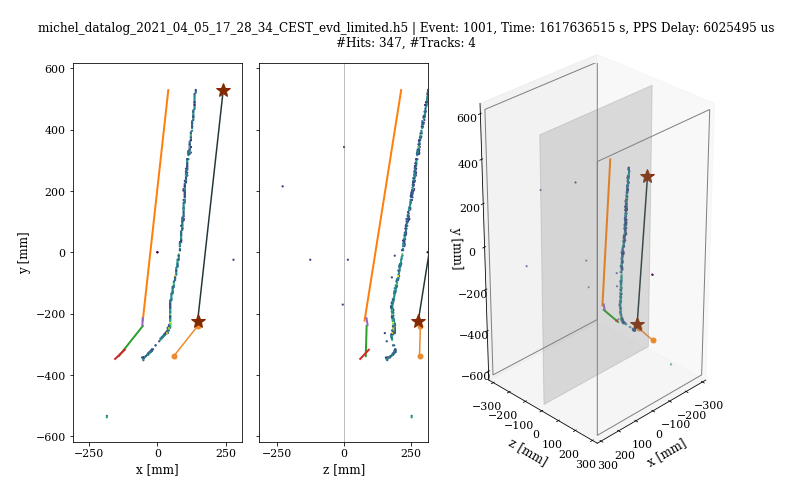

In [9]:
# good = [0,1,2,4,6,9,10,11,14,19,20,23,24,28,30,33,34,35,36,37,40,42,43,44,47,48,50,52]
good = [1]
for g in tqdm(good):
    michel = ndf.iloc[g]
    tOffset = 100

    reload(evd)
    reload(cl)
    fig, ax1, ax2, ax3 = evd.SmallEventDisplay(michel['id_eventId'],cpath,cdata,geometryHelper,rot=45,showTracks=True,xTrackOffset=-tOffset)
    # Additional plotting: MUON
    mucol = [mc[0],mc[2]]
    ax1.plot([michel['pos_start'][0]+tOffset,michel['pos_end'][0]+tOffset],
             [michel['pos_start'][1],michel['pos_end'][1]],
             ls='-',color=mucol[0],marker='*',markersize=15,mec=mucol[1],mfc=mucol[1])
    ax2.plot([michel['pos_start'][2]+tOffset,michel['pos_end'][2]+tOffset],
             [michel['pos_start'][1],michel['pos_end'][1]],
             ls='-',color=mucol[0],marker='*',markersize=15,mec=mucol[1],mfc=mucol[1])
    ax3.plot([michel['pos_start'][0],michel['pos_end'][0]],
             [michel['pos_start'][2]+tOffset,michel['pos_end'][2]+tOffset],
             [michel['pos_start'][1],michel['pos_end'][1]],
             ls='-',color=mucol[0],marker='*',markersize=15,mec=mucol[1],mfc=mucol[1])

    # Plot the stitches
    xs = np.array([s[0] for s in michel['stitch_locStitch']])
    ys = np.array([s[1] for s in michel['stitch_locStitch']])
    zs = np.array([s[2] for s in michel['stitch_locStitch']])
    ax1.plot(xs+tOffset,ys,ls='',marker='*',markersize=10,mec='gray',mfc='gray')
    ax2.plot(zs+tOffset,ys,ls='',marker='*',markersize=10,mec='gray',mfc='gray')
    ax3.plot(xs,zs+tOffset,ys,ls='',marker='*',markersize=10,mec='gray',mfc='gray')


    # Additional plotting: ELECTRON
    ecol = [mc[1],mc[1]]
    ax1.plot([michel['e_pos_start'][0]+tOffset,michel['e_pos_end'][0]+tOffset],
             [michel['e_pos_start'][1],michel['e_pos_end'][1]],
             ls='-',color=ecol[0],marker='o',markersize=5,mec=ecol[1],mfc=ecol[1],zorder=-1)
    ax2.plot([michel['e_pos_start'][2]+tOffset,michel['e_pos_end'][2]+tOffset],
             [michel['e_pos_start'][1],michel['e_pos_end'][1]],
             ls='-',color=ecol[0],marker='o',markersize=5,mec=ecol[1],mfc=ecol[1],zorder=-1)
    ax3.plot([michel['e_pos_start'][0],michel['e_pos_end'][0]],
             [michel['e_pos_start'][2]+tOffset,michel['e_pos_end'][2]+tOffset],
             [michel['e_pos_start'][1],michel['e_pos_end'][1]],
             ls='-',color=ecol[0],marker='o',markersize=5,mec=ecol[1],mfc=ecol[1],zorder=-1)

    plt.savefig(f"/home/dporzio/App/MichelElectrons_Analysis/Plots/EarlyMichels/michel_{michel['id_eventId']}.png",bbox_inches='tight', pad_inches=0.3)
# plt.show()

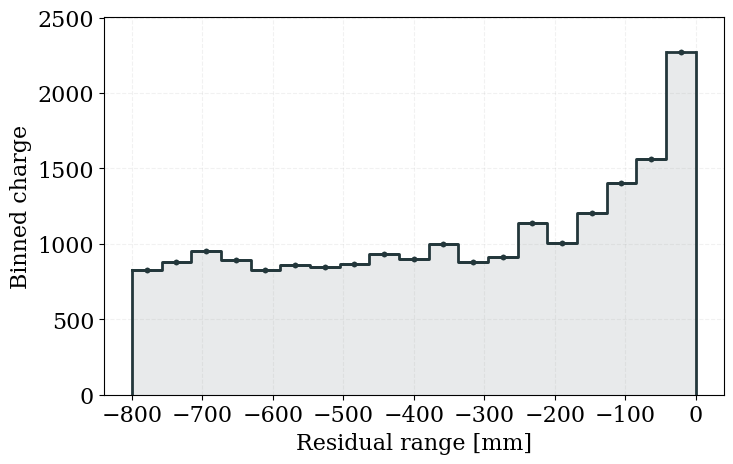

In [386]:
good = [0,1,2,4,6,9,10,11,14,19,20,23,24,28,30,33,34,35,36,37,40,42,43,44,47,48,50,52]
rrbins = np.linspace(-800,0,20)
rrvals_tot = np.zeros(len(rrbins)-1)
rrweights = np.zeros(len(rrbins)-1)

for g in good:
    michel = ndf.iloc[g]

    rawcharge, charge, distance = [], [], []
    tref = cl.GetEventStartTime(michel['id_eventId'],cdata)

    for tId in michel['stitch_iStitches']:
        hits = h_hits[h_tracks[tId]['hit_ref']]
        for hit in hits:
            rawcharge.append(hit['q_raw'])
            charge.append(hit['q'])
            hz = cl.ConvertTimeToZ(geometryHelper,hit['iogroup'],hit['iochannel'],hit['ts'],tref)
            hitLoc = [hit['px'],hit['py'],hz]
            distance.append(-1*EuDistance(michel['pos_end'],hitLoc))
    resRange = pd.DataFrame()
    resRange['charge'] = charge
    resRange['rawcharge'] = rawcharge
    resRange['distance'] = distance
    
    resRange = resRange.sort_values(['distance'])
    rrvals = np.array([resRange.query(f'distance>{rrbins[i]} & distance<{rrbins[i+1]}')['charge'].sum() for i in range(len(rrbins)-1)])
    rrweights = rrweights+(rrvals>0)
    rrvals_tot = rrvals_tot + rrvals

rrvals_tot = rrvals_tot/rrweights
plt.figure(figsize=(8,5),facecolor='white',dpi=100)
hp.HepPlot(rrbins[:-1],rrvals_tot,color=mc[0])
plt.grid(True,ls='--',color='C7',alpha=0.1)
plt.xlabel('Residual range [mm]')
plt.ylabel('Binned charge')
# plt.xlim(min(resRange['distance']),0)
plt.show()

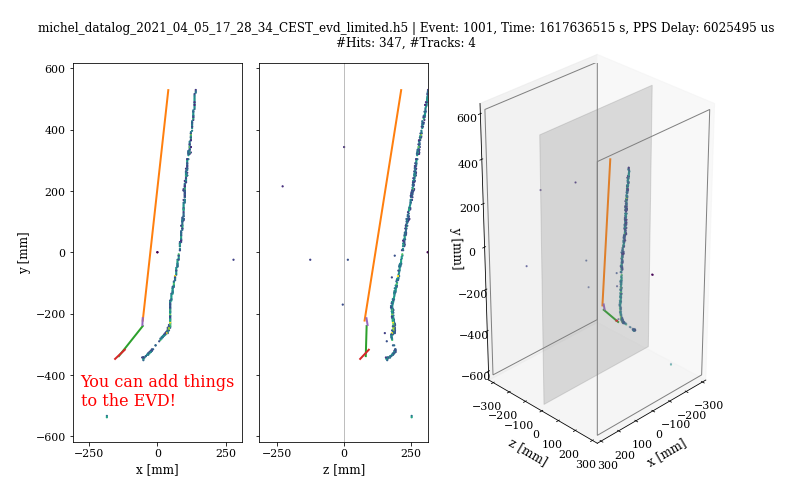

In [23]:
fig, ax1, ax2, ax3 = evd.SmallEventDisplay(1001,cpath,cdata,geometryHelper,rot=45,showTracks=True,xTrackOffset=-tOffset)
ax1.text(-280,-500,'You can add things\nto the EVD!',c='red')

plt.show()